In [1]:
from IPython.display import clear_output, display, HTML
from urllib.parse import urlencode
from datetime import datetime, timedelta
from collections import OrderedDict
import queue
import requests
import threading
import pandas as pd
import itertools
from math import isnan
import pytz
import json
import csv
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick2_ochl, candlestick_ochl
from matplotlib.dates import date2num, DateFormatter
from matplotlib import pyplot as plt, ticker, style
from time import sleep
    
style.use('ggplot')

TOP_ITEMS_COUNT = 10
DATA_TIMEZONE = pytz.timezone("US/Eastern")
CLIENT_TIMEZONE = pytz.timezone('America/Los_Angeles')
periods = [1, 5, 15, 30, 60, "All day"]

def get_now():
    now = datetime.now(tz=CLIENT_TIMEZONE)
    weekday = now.isoweekday()
    if weekday > 5:
        now = (now - timedelta(days=weekday - 5)).replace(hour=15)
    return now

now = get_now()    
now

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


datetime.datetime(2019, 3, 15, 15, 41, 33, 906523, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>)

In [2]:
def get_symbols():
    with open("n14_symbols.csv", "r") as f:
        symbols = f.read().split()
    return list(set(symbols))
symbols = get_symbols()
len(symbols)

3198

In [5]:
def get_minute_data(symbol, now):
    now = now.replace(second=0, microsecond=0)
    start = now.replace(hour=6, minute=30)
    if start > now:
        raise ValueError("It's too early")
    
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1m&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), now.timestamp())
    print(url)
    try:
        page = requests.get(url)
    except Exception as e:
        print("Exception while getting {}".format(symbol), e)
    else:
        result = page.json()['chart']['result']
        if not result:
            print(symbol, page.json())
            return

        data = result[0]
        quote = data['indicators']['quote'][0]
        if 'timestamp' not in data:
            return
        times = data['timestamp']
        period = data['meta']['currentTradingPeriod']['regular']
        start, end = period['start'], period['end']
        del quote['volume']
        quote['index'] = [datetime.fromtimestamp(t, tz=DATA_TIMEZONE).astimezone(now.tzinfo) for t in times]

        return quote

raw_data = get_minute_data('AAPL', now) # SRCE
raw_data

https://query1.finance.yahoo.com/v7/finance/chart/AAPL?period1=1552656600&period2=1552689660&interval=1m&indicators=quote&includeTimestamps=true&events=div%7Csplit%7Cearn


{'open': [184.83999633789062,
  184.75,
  184.5399932861328,
  184.0399932861328,
  183.92999267578125,
  184.22000122070312,
  184.2899932861328,
  183.9600067138672,
  183.85000610351562,
  183.92999267578125,
  183.88690185546875,
  184.07000732421875,
  184.0399932861328,
  184.3300018310547,
  184.2100067138672,
  184.25,
  184.13999938964844,
  184.11000061035156,
  184.11000061035156,
  184.33999633789062,
  184.39999389648438,
  184.47999572753906,
  184.593505859375,
  184.6300048828125,
  184.67579650878906,
  184.69320678710938,
  184.86000061035156,
  184.91000366210938,
  184.88999938964844,
  184.8699951171875,
  184.91000366210938,
  184.9949951171875,
  184.94000244140625,
  184.77000427246094,
  184.74009704589844,
  184.65660095214844,
  184.8699951171875,
  184.8975067138672,
  184.72999572753906,
  184.5500030517578,
  184.52999877929688,
  184.5399932861328,
  184.5500030517578,
  184.66000366210938,
  184.80999755859375,
  184.86000061035156,
  184.81399536132812,

In [6]:
def get_df_from_raw_data(rd):
    assert rd and "index" in rd, "An unexpected input: {}".format(rd)
    index = rd['index']
    del rd['index']
    df = pd.DataFrame(rd, index=index)
    df['n_low'] = df.low < df.low.shift(1)
    df['bear_velocity'] = df.n_low.rolling(window=10).sum() * 10
    df['n_high'] = df.high > df.high.shift(1)
    df['bull_velocity'] = df.n_high.rolling(window=10).sum() * 10

    df['min_low'] = df.low.rolling(window=len(df), min_periods=1).min()
    df['min_low_open'] = (df.min_low / df.open - 1) * 100
    df['close_min_low'] = (df.close / df.min_low - 1) * 100
    return df

get_df_from_raw_data(raw_data)[:10]

,open,close,high,low,n_low,bear_velocity,n_high,bull_velocity,min_low,min_low_open,close_min_low
2019-03-15 06:30:00-07:00,184.839996,184.750000,184.910004,184.380005,False,NaN,False,NaN,184.380005,-0.248859,0.200670
2019-03-15 06:31:00-07:00,184.750000,184.562607,184.750000,184.330307,True,NaN,False,NaN,184.330307,-0.227168,0.126024
2019-03-15 06:32:00-07:00,184.539993,184.070007,184.550003,184.039993,True,NaN,False,NaN,184.039993,-0.270944,0.016308
2019-03-15 06:33:00-07:00,184.039993,183.919998,184.119995,183.919998,True,NaN,False,NaN,183.919998,-0.065201,0.000000
2019-03-15 06:34:00-07:00,183.929993,184.229996,184.350006,183.929993,False,NaN,True,NaN,183.919998,-0.005434,0.168550
2019-03-15 06:35:00-07:00,184.220001,184.300003,184.449997,184.179993,False,NaN,True,NaN,183.919998,-0.162850,0.206614
2019-03-15 06:36:00-07:00,184.289993,183.929993,184.289993,183.820007,True,NaN,False,NaN,183.820007,-0.255025,0.059833
2019-03-15 06:37:00-07:00,183.960007,183.843903,183.966095,183.740005,True,NaN,False,NaN,183.740005,-0.119592,0.056546
2019-03-15 06:38:00-07:00,183.850006,183.924393,183.990005,183.839996,False,NaN,True,NaN,183.740005,-0.059832,0.100352
2019-03-15 06:39:00-07:00,183.929993,183.891602,184.009506,183.869995,False,50.0,True,40.0,183.740005,-0.103293,0.082506


In [5]:
def load_data(symbols, time):
    
    num_worker_threads = 100
    
    def worker():
        while True:
            symbol = q.get()
            if symbol is None:
                break
            
            # GET DATA
            data = get_minute_data(symbol, time)
            if data is not None:
                r.put((symbol, data))
            
            q.task_done()

    q = queue.Queue() # queue with arguments for the 'get_transactions' function
    r = queue.Queue() # queue with raw responses

    threads = []
    for i in range(num_worker_threads):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)

    for symbol in symbols:
        q.put(symbol)

    # block until all tasks are done
    q.join()

    # stop workers
    for i in range(num_worker_threads):
        q.put(None)

    for t in threads:
        t.join()
    
    # get and save data
    minute_data = {}
    symbols_sort_data = []
    while True:
        try:
            symbol, raw_data = r.get(block=False)
        except queue.Empty:
            break
        else:
            minute_data[symbol] = raw_data

            df = pd.DataFrame(dict(low=raw_data['low']), index=raw_data['index'])
            if len(df):
                df['n_low'] = df.low < df.low.shift(1)
                df['bear_velocity'] = df.n_low.rolling(window=10).sum()
                last_minute_bear_velicity = df.bear_velocity[-1]
                symbols_sort_data.append((last_minute_bear_velicity, symbol))
    
    top_symbols = [s[1] for s in sorted(symbols_sort_data, reverse=True)][:10]
    minute_data_for_top_symbols = [(symbol, get_df_from_raw_data(minute_data[symbol]))
                                   for symbol in top_symbols]
    
    return minute_data_for_top_symbols

load_data(("SRCE", "GOOG"), now)

[('GOOG',
                                   close         high          low         open  \
  2018-05-04 06:30:00-07:00  1017.855591  1019.409973  1016.900024  1016.900024   
  2018-05-04 06:31:00-07:00  1019.635010  1019.989990  1018.820007  1018.820007   
  2018-05-04 06:32:00-07:00  1020.619995  1020.859985  1019.270020  1019.880005   
  2018-05-04 06:33:00-07:00  1018.049988  1020.590027  1018.049988  1020.590027   
  2018-05-04 06:34:00-07:00  1018.590027  1018.760010  1017.159973  1017.594421   
  2018-05-04 06:35:00-07:00  1020.034973  1020.200012  1018.500000  1018.500000   
  2018-05-04 06:36:00-07:00  1020.456177  1021.000000  1020.456177  1021.000000   
  2018-05-04 06:37:00-07:00  1020.650024  1021.369995  1020.075012  1020.474976   
  2018-05-04 06:38:00-07:00  1021.309998  1021.719971  1020.650024  1020.650024   
  2018-05-04 06:39:00-07:00  1022.000000  1022.000000  1020.599976  1020.770020   
  2018-05-04 06:40:00-07:00  1019.880005  1021.979980  1019.460022  1021.9799

10m Bear Velocity,Min Low / Open,Symbol,Close / Min Low,10m Bull Velocity
70.0,-3.0443194308324872,PI,3.3386333771154186,10.0
70.0,-2.7058784687834403,MPAA,3.0289230032828574,40.0
70.0,-3.1060928976463953,EXAS,3.2681092108738152,30.0
50.0,-1.5449144597732944,SIMO,1.6588160808000962,30.0
50.0,-4.617922638403094,SAVE,4.8703129381886034,30.0
50.0,-1.9926775185472811,PLCE,1.9502062025901212,30.0
50.0,-6.636158982263229,CLUB,7.8431392715143655,30.0
50.0,-2.0669295403627608,BOFI,2.1859270064373604,30.0
50.0,-1.7429842811926721,AMBC,1.8641093742347792,20.0
50.0,-4.229898272479138,AIMT,4.113281590124274,50.0


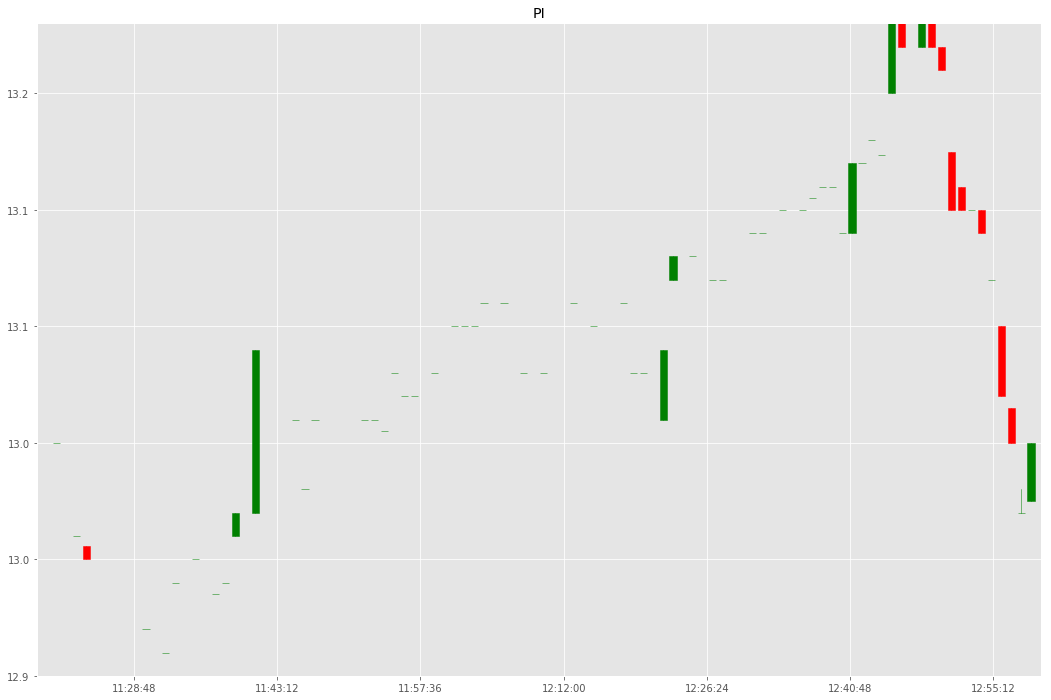

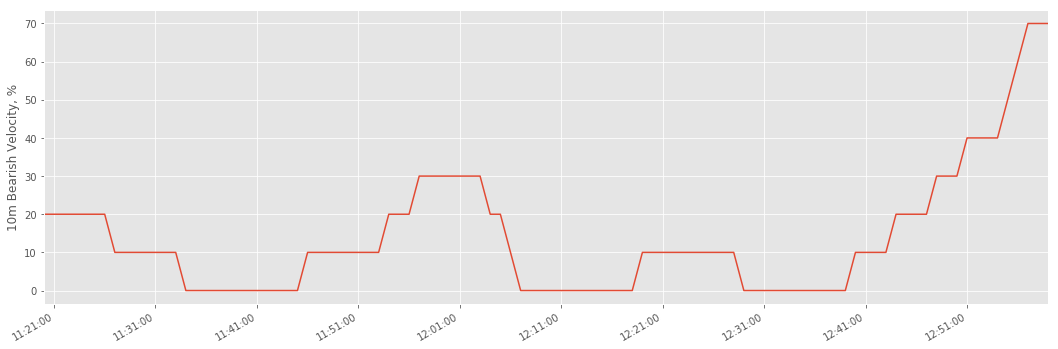

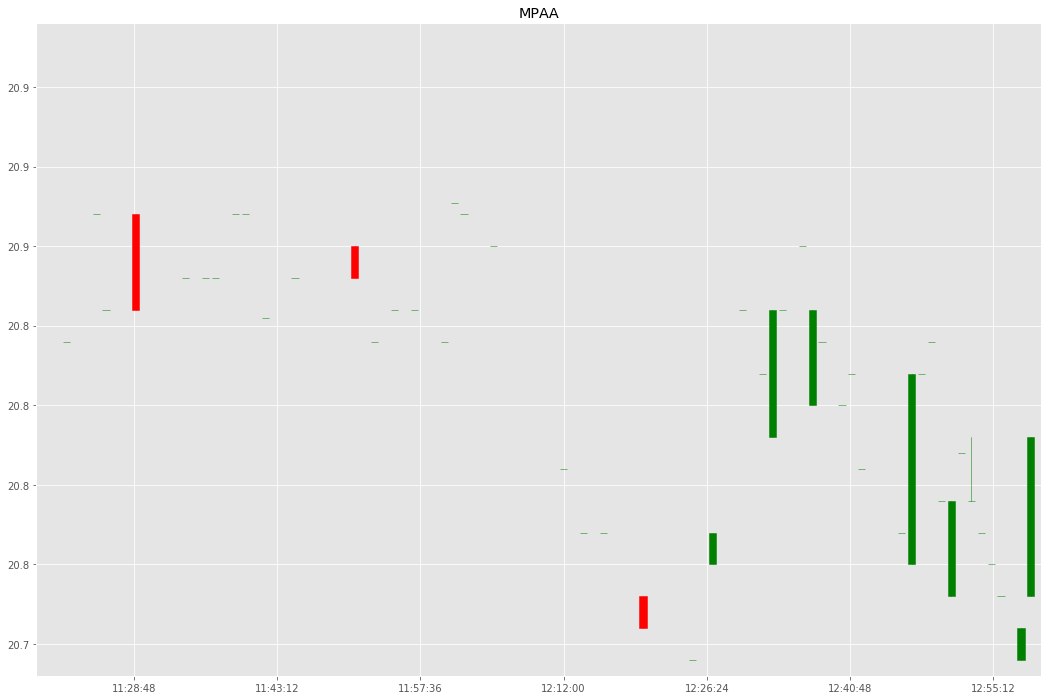

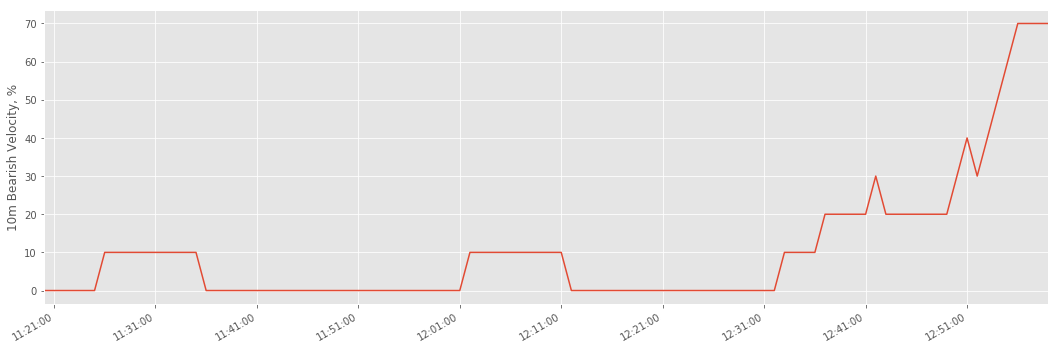

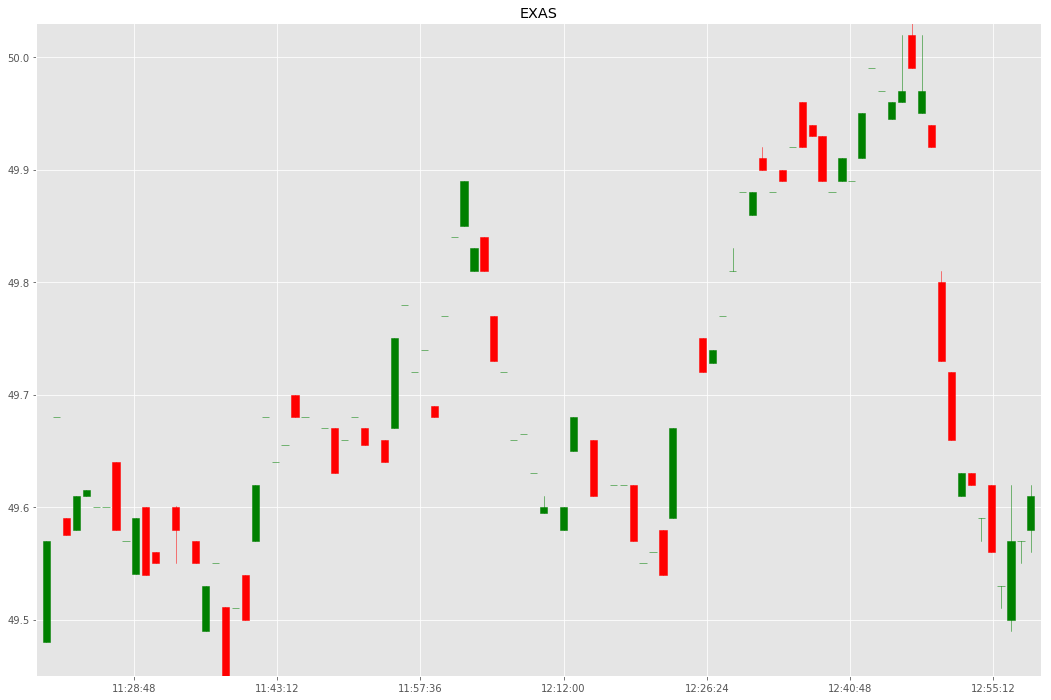

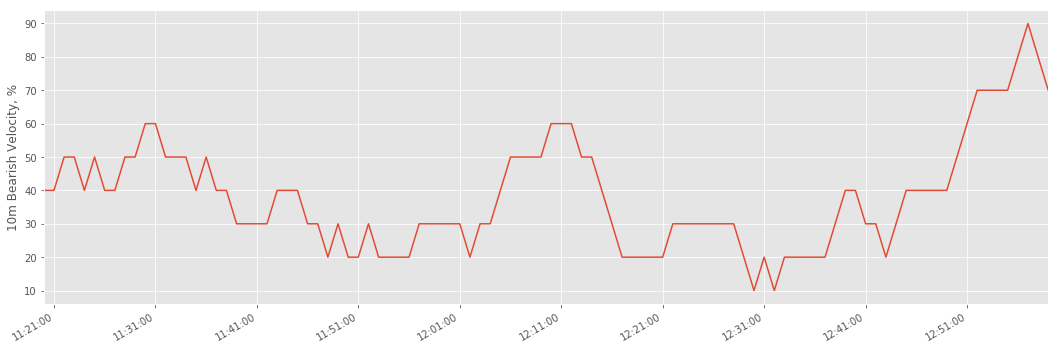

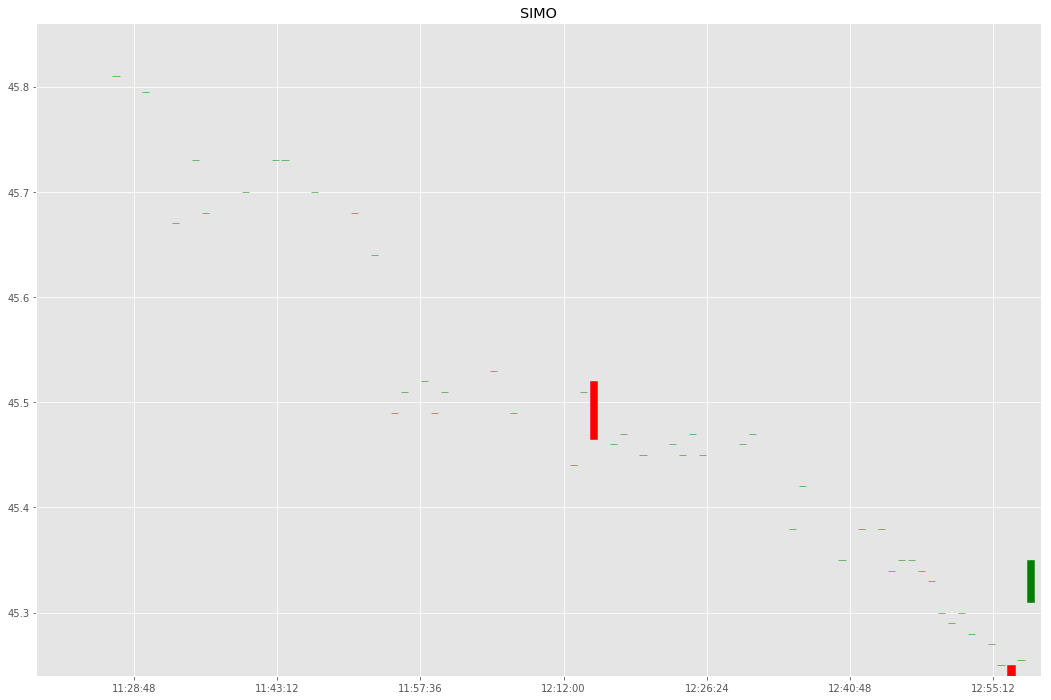

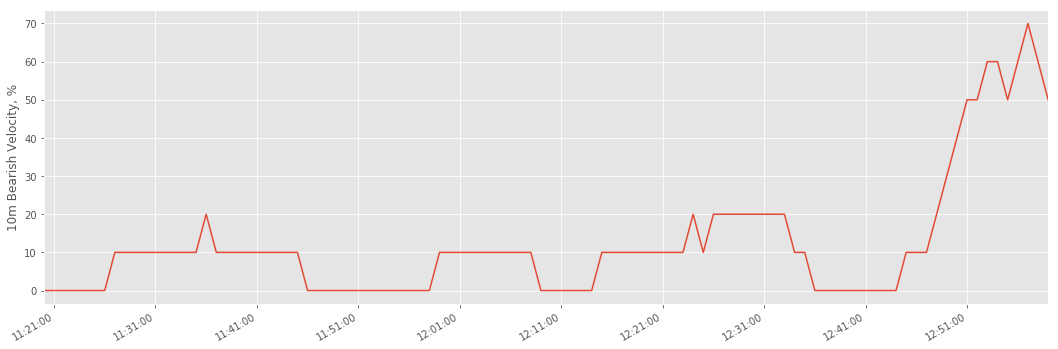

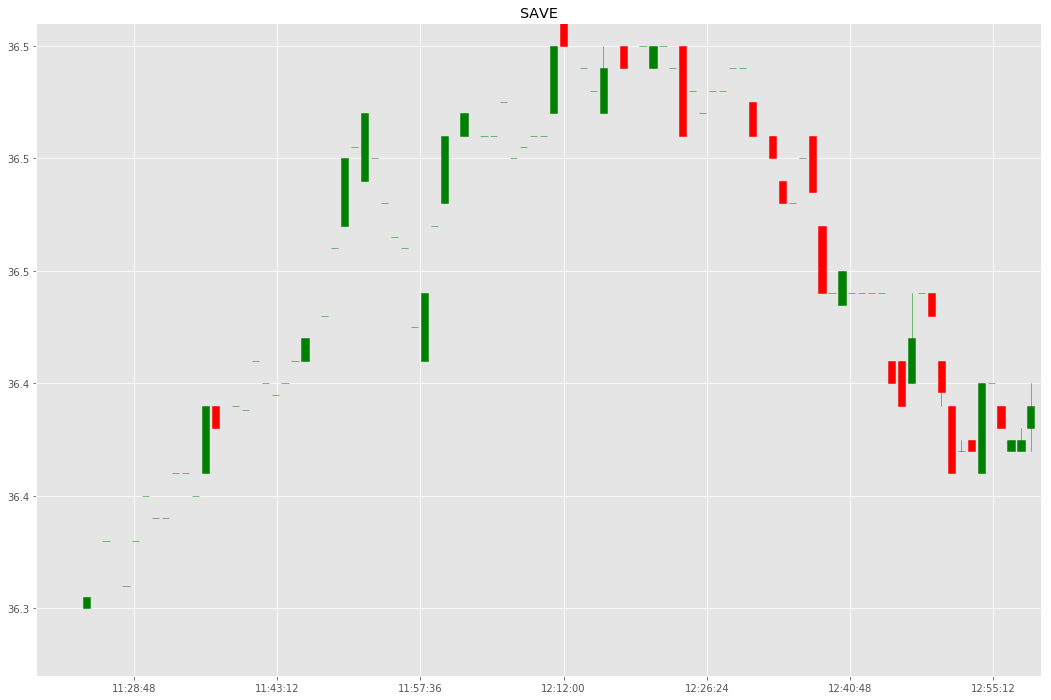

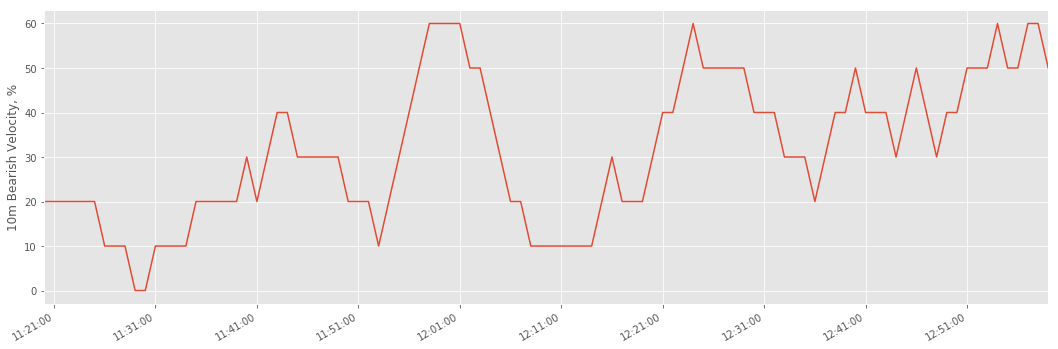

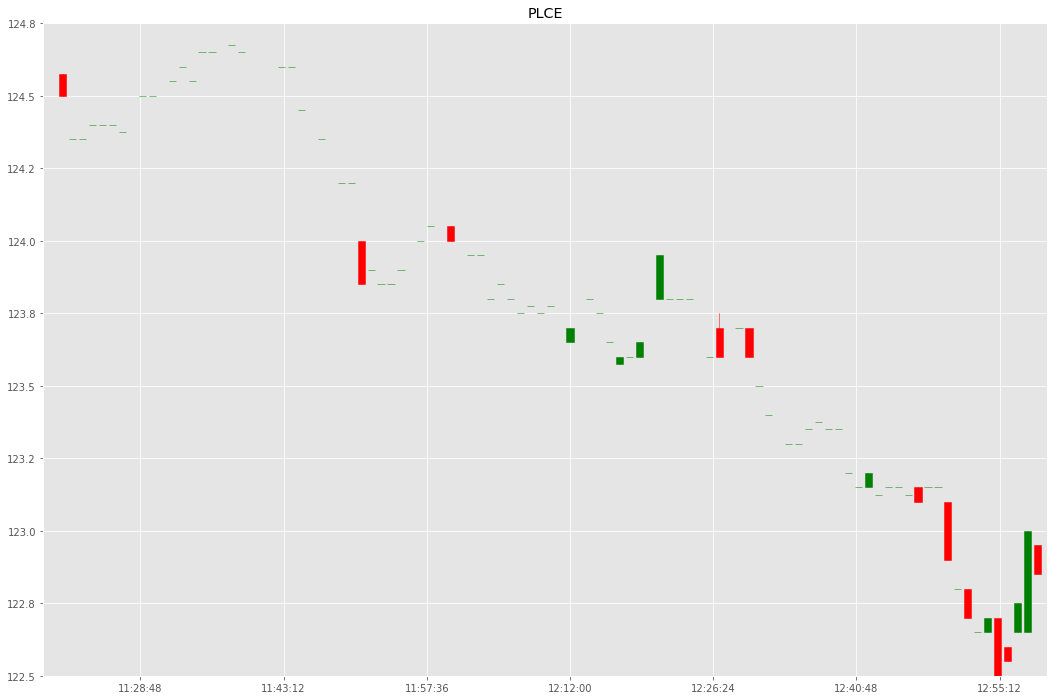

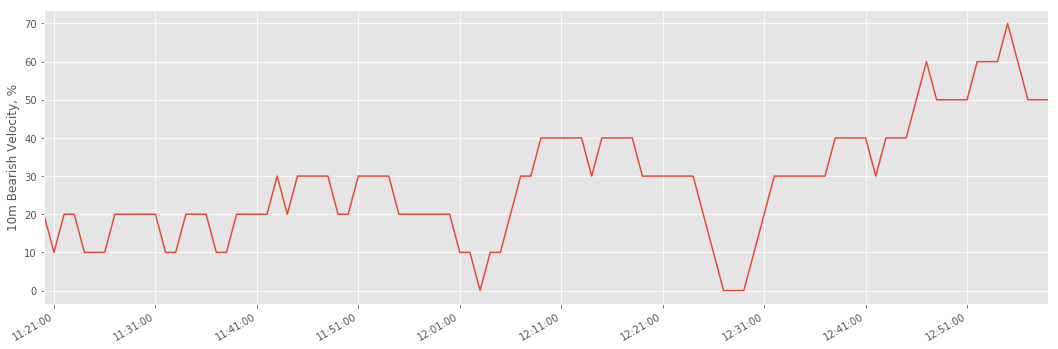

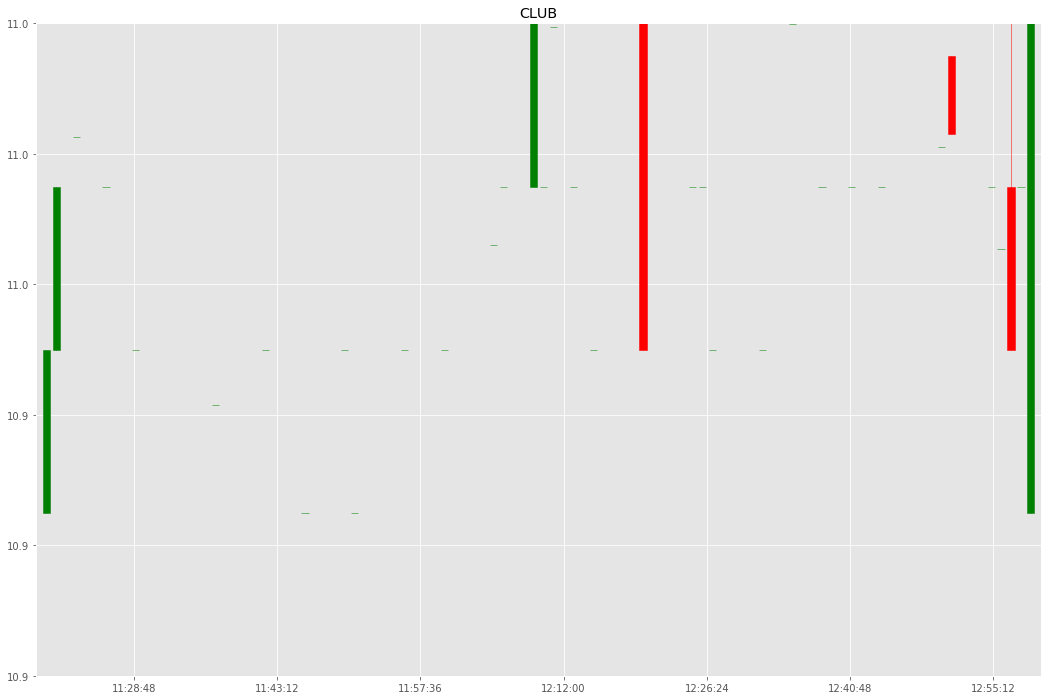

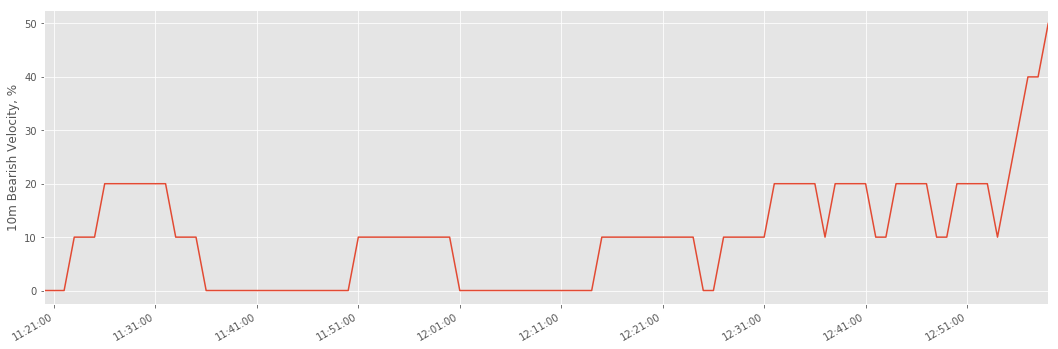

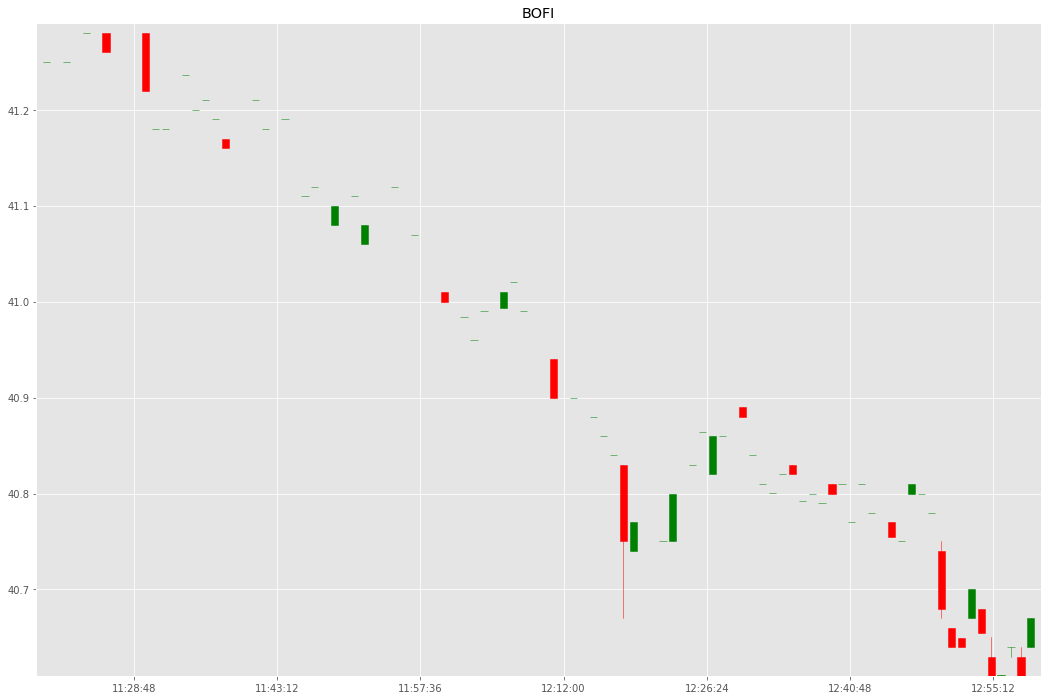

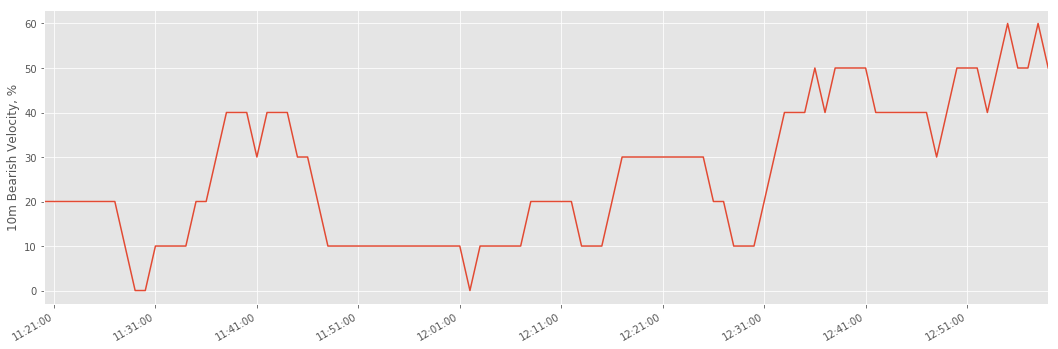

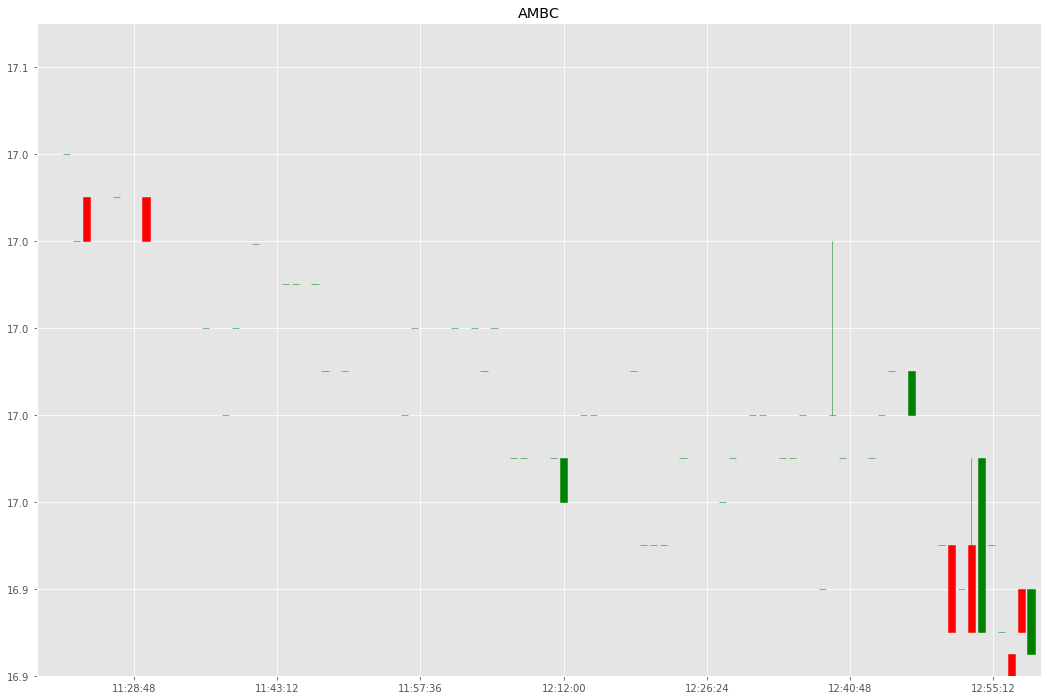

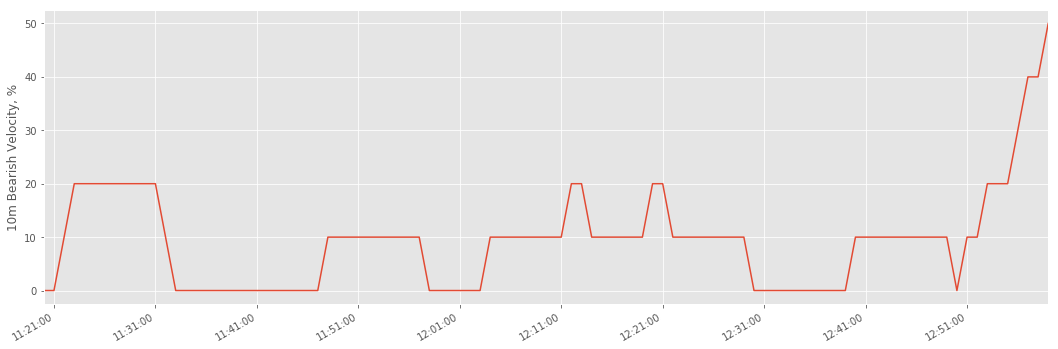

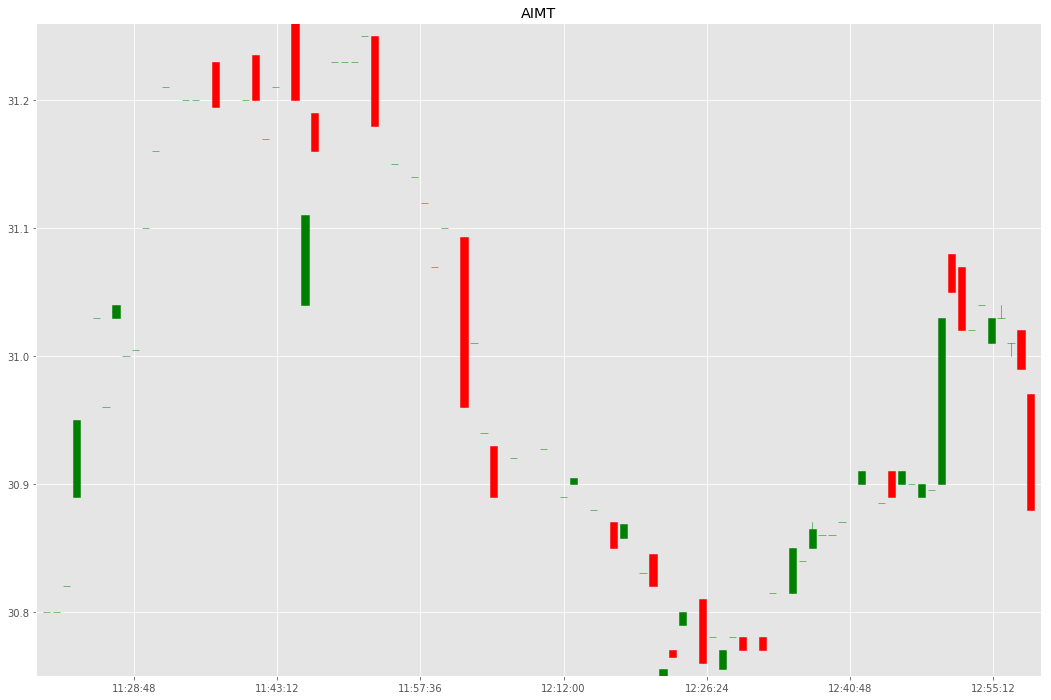

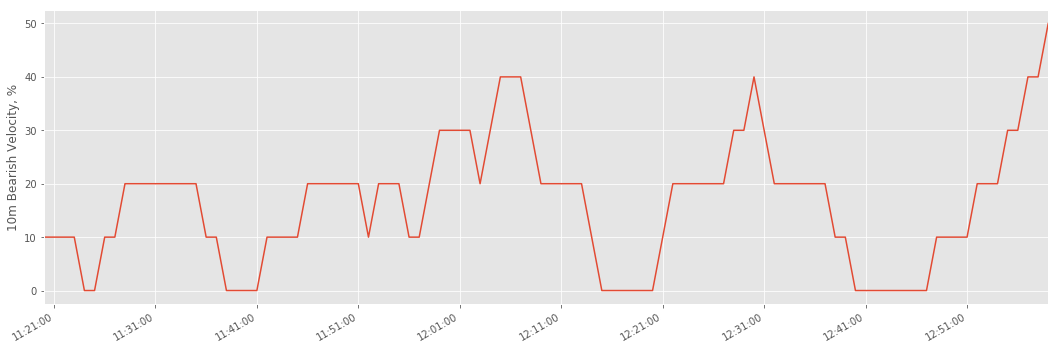

period 0:00:13.457004


KeyboardInterrupt: 

In [7]:
prev_time = None
timeFormatter = DateFormatter('%H:%M:%S', tz=CLIENT_TIMEZONE)
now = get_now()
symbols = get_symbols()

while True:
    start = datetime.now()    
    if prev_time:
        seconds_since_update = (start - prev_time).seconds
        if seconds_since_update < 60:
            sleep(60 - seconds_since_update)    
    
    top_symbols_data = load_data(symbols, now) 
    clear_output()
    
    display(HTML("<h3>Top 10 V Bottom Candidates</h3>"))
    
    table = "<table width='100%'>"\
            "<tr><th>10m Bear Velocity</th><th>Min Low / Open</th><th>Symbol</th>"\
            "<th>Close / Min Low</th><th>10m Bull Velocity</th></tr>"
    for symbol, df in top_symbols_data: 
        latest_row = df.iloc[-1]
        
        table += "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(
            latest_row["bear_velocity"],
            latest_row["min_low_open"],
            symbol,
            latest_row["close_min_low"],
            latest_row["bull_velocity"],
        )
        
        # plot data
        sub_df = df[-100:]  
        
        fig = plt.figure(figsize=(18, 12)) 
        ax1 = plt.subplot(111)
        ax1.set_title(symbol)
        candlestick_ochl(
            ax1, 
            ((date2num(r.Index), r.open, r.close, r.high, r.low) for r in sub_df.itertuples()), 
            width=.0005,
            colorup='g',  
            colordown='r',
        )
        ax1.xaxis.set_major_formatter(timeFormatter)
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,p: "%.1f" % x))
        x_min = date2num(sub_df.index.min() - timedelta(seconds=60))
        x_max = date2num(sub_df.index.max() + timedelta(seconds=60))
        ax1.set_xlim(x_min, x_max)
        ax1.set_ylim(sub_df.low.min(), sub_df.high.max())  
        
        fig = plt.figure(figsize=(18, 6)) 
        ax2 = plt.subplot(111)
        sub_df.bear_velocity.plot()
        ax2.xaxis.set_major_formatter(timeFormatter)
        ax2.set_ylabel('10m Bearish Velocity, %')
        
    
    table += "</table>"    
    display(HTML(table))
    
    display(HTML("<h3>Individual charts</h3>"))
    
    plt.show()    
    
    print("period", (datetime.now() - start))
    prev_time = start